In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
## COMMENT - code is as markdown and should be changed to code before running!!!

# Molecule retrieval from Zinc20 smi files

In [2]:
Is_data_prepared = True
if not Is_data_prepared:
    
    tranche_dirs = ['FK', 'DC', 'BB', 'JA', 'HE', 'GA', 'KG', 'IC', 'CB', 'HJ']

### location of zinc20 files and resulting h5 store

### The files containing SMILES from ZINC 20 db can be download by running ```ZINC-downloader-2D-smi.wget``` - these requires a lot of free space

In [3]:
if not Is_data_prepared:
    zinc20_path = Path("/storage/hdd1/smiles/zinc20/tranche_2.5_375/") #Path to place where datasets are downloaded
    tranches_name = "_".join(tranche_dirs)
    store_path = Path("../data/zinc20_"+tranches_name+".h5")

### main retrieval loop

#pip install tables

In [4]:
if not Is_data_prepared:
    from_raw_files = True
    if from_raw_files:
        store = pd.HDFStore(store_path.absolute().as_posix(), "w")
        for subdir in tranche_dirs:
            smiles_df = pd.DataFrame(columns=["smiles"])
            dir = (zinc20_path/subdir).absolute().as_posix()
            smiles_files = os.listdir(dir)
            for smiles_file in smiles_files:
                path = (zinc20_path/subdir/smiles_file).absolute().as_posix()
                try:
                    df = pd.read_csv(path, sep=" ").set_index("zinc_id")
                    smiles_df = pd.concat([smiles_df, df], axis=0)
                except pd.errors.EmptyDataError:
                    pass
            store[subdir] = smiles_df
        store.close()

### data sampling, from each subdirectory certain number of compounds is randomly sampled

In [5]:
if not Is_data_prepared:
    store = pd.HDFStore(store_path.absolute().as_posix(), "r")
    smiles_df = pd.DataFrame(columns=["smiles"])
    n_sample = 100000
    for tranche in store.keys():
        df = store[tranche]
        n_sample_ = min(df.shape[0], n_sample)
        df = df.sample(n_sample_)
        smiles_df = pd.concat([smiles_df, df], axis=0)
    store.close()
    del df

In [6]:
if not Is_data_prepared:
    resulting_file_name = "zinc20_"+tranches_name+"_processed.parquet"
    resulting_df_path = Path("../data")/resulting_file_name
    smiles_df.to_parquet(resulting_df_path.absolute().as_posix())

In [7]:
if not Is_data_prepared:
    os.remove("zinc20_FK_DC_BB_JA_HE_GA_KG_IC_CB_HJ.h5")

### Check length of translated SELFIES

In [8]:
import selfies as sf
from rdkit import Chem
import pandas as pd

In [9]:
data_to_read = pd.read_parquet('zinc20_FK_DC_BB_JA_HE_GA_KG_IC_CB_HJ_processed.parquet')

In [10]:
data_to_read = data_to_read.reset_index()

In [11]:
data_to_read.shape

(935512, 2)

In [12]:
data_to_read = data_to_read.drop_duplicates(subset=['smiles'])
data_to_read = data_to_read.reset_index()
del data_to_read['level_0']

In [13]:
data_to_read.shape

(935475, 2)

In [14]:
data_to_read.head()

,index,smiles
0,336474016,CC1(C)COCCN1C(=O)CCNC(N)=O
1,1086464356,CCN[C@H]1C[C@H](CNC(=O)[C@@H]2CNC(=O)N2)C1
2,248404898,CO[C@H](C)CN1CCOC[C@H]1C(N)=O
3,1574709678,O=C(O)CCNC(=O)c1ccc(CO)nc1
4,1119650207,C[C@@H](CC(=O)O)C(=O)N1C[C@H](O)C[C@H]1CO


## OLD code
File_with_cannonical_SMILES_exist = True #change to false if file is not present
if File_with_cannonical_SMILES_exist:
    data_to_read = pd.read_parquet('zinc20_FK_DC_BB_JA_HE_GA_KG_IC_CB_HJ_processed_neutralized.parquet')
    data_to_read['mol'] = [Chem.MolFromSmiles(smi) for smi in data_to_read['smiles']]
    data_to_read['canonical_SMILES'] = data_to_read['mol']
    for i in range(len(data_to_read['mol'])):
        try:
            
            data_to_read['canonical_SMILES'][i] = Chem.MolToSmiles(data_to_read['mol'][i], isomericSmiles=False)
        except:
            data_to_read['canonical_SMILES'][i] = None
    data_to_read = data_to_read[data_to_read.canonical_SMILES != None]
    data_to_read = data_to_read.reset_index() #drop=True
    print(data_to_read.shape)
    data_to_read = data_to_read.drop_duplicates(subset=['canonical_SMILES'])
    data_to_read = data_to_read.reset_index() #drop=True
    print(data_to_read.shape)
    del data_to_read['mol']
    data_to_read.to_parquet('zinc20_FK_DC_BB_JA_HE_GA_KG_IC_CB_HJ_processed_canonical_.parquet')
else:
    data_to_read = pd.read_parquet('zinc20_FK_DC_BB_JA_HE_GA_KG_IC_CB_HJ_processed.parquet')
    data_to_read = data_to_read.reset_index()
    data_to_read['smiles'] = [Chem.MolToSmiles(get_parent_mol(Chem.MolFromSmiles(smiles), neutralize=True, check_exclusion=True, verbose=False)[0]) for smiles in data_to_read['smiles']]
    print(data_to_read.shape)
    data_to_read = data_to_read.drop_duplicates(subset=['smiles'])
    print(data_to_read.shape)
    data_to_read['mol'] = [Chem.MolFromSmiles(smi) for smi in data_to_read['smiles']]
    data_to_read['canonical_SMILES'] = data_to_read['mol']
    for i in range(len(data_to_read['mol'])):
        try:
            
            data_to_read['canonical_SMILES'][i] = Chem.MolToSmiles(data_to_read['mol'][i], isomericSmiles=False)
        except:
            data_to_read['canonical_SMILES'][i] = None
    data_to_read = data_to_read[data_to_read.canonical_SMILES != None]
    data_to_read = data_to_read.reset_index() #drop=True
    print(data_to_read.shape)
    data_to_read = data_to_read.drop_duplicates(subset=['canonical_SMILES'])
    data_to_read = data_to_read.reset_index() #drop=True
    print(data_to_read.shape)
    del data_to_read['mol']
    data_to_read.to_parquet('zinc20_FK_DC_BB_JA_HE_GA_KG_IC_CB_HJ_processed_canonical_.parquet')
    

In [15]:
data_to_read['SELFIES'] = [sf.encoder(smiles) for smiles in data_to_read['smiles']]

In [16]:
data_to_read.shape

(935475, 3)

In [17]:
def SELFIES_length(SELFIES_mol):
    length_selfies = []
    try:
        length_selfies.append(SELFIES_mol.count('['))
    except:
        print('Something went wrong, check source code...')
    return max(length_selfies)

In [18]:
data_to_read['SELFIES_length'] = [SELFIES_length(SELFIES) for SELFIES in data_to_read['SELFIES']]

<AxesSubplot:>

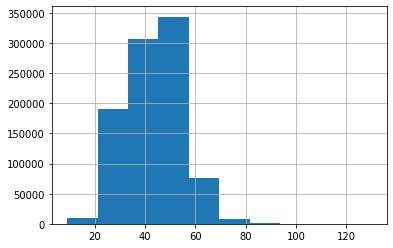

In [19]:
data_to_read['SELFIES_length'].hist()

In [20]:
data_to_read['SELFIES_length'].max()

130

<AxesSubplot:>

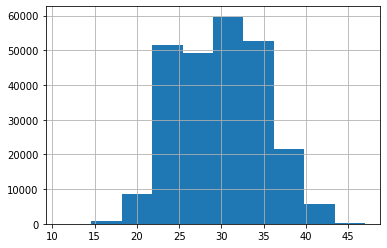

In [21]:
data_to_read['SELFIES_length'][:250000].hist()

In [22]:
data_to_read['SELFIES_length'][:250000].max()

47

In [23]:
dataa = data_to_read[(data_to_read['SELFIES_length'] <= 50) & (data_to_read['SELFIES_length'] >= 30)]

In [24]:
dataa

,index,smiles,SELFIES,SELFIES_length
15,635668639,CN1CCN(C(=O)[C@H]2C[C@@H](O)C2)C(C)(C)C1=O,[C][N][C][C][N][Branch1][=C][C][=Branch1][C][=...,31
30,281714625,C#CCN(C(=O)[C@@H]1CC[C@@H](C(N)=O)O1)C1CC1,[C][#C][C][N][Branch2][Ring1][Ring1][C][=Branc...,30
36,899336347,CN1C(=O)C(=Cc2ncnn2C)C(=O)N(C)C1=O,[C][N][C][=Branch1][C][=O][C][=Branch1][#Branc...,30
69,1602691393,C#CCN(CC(=O)O)C(=O)[C@@H]1C[C@@H]2O[C@H]1[C@H]...,[C][#C][C][N][Branch1][#Branch1][C][C][=Branch...,30
78,909304553,C=C[C@](C)(O)C(=O)N1CC[C@](F)(C(=O)O)C1,[C][=C][C@][Branch1][C][C][Branch1][C][O][C][=...,30
...,...,...,...,...
935322,514388722,CCOc1ccc(S(=O)(=O)N2CCCCC2)cc1NC(=O)CSc1nnnn1C...,[C][C][O][C][=C][C][=C][Branch1][S][S][=Branch...,50
935345,409101685,COC(=O)COc1c(I)cc(/C=N/Nc2ncccc2[N+](=O)[O-])cc1I,[C][O][C][=Branch1][C][=O][C][O][C][=C][Branch...,39
935372,409238714,CCOc1c(I)cc(/C=C2/NC(=O)N(CC)C2=O)cc1I,[C][C][O][C][=C][Branch1][C][I][C][=C][Branch1...,33
935386,710361,COc1ccc(NS(=O)(=O)c2ccc(NC(=O)c3cccc(I)c3)cc2)nn1,[C][O][C][=C][C][=C][Branch2][Ring2][Ring1][N]...,48


<AxesSubplot:>

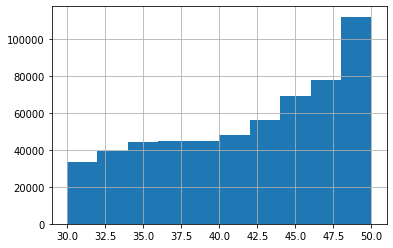

In [25]:
dataa['SELFIES_length'].hist()

In [26]:
data = dataa.sort_values(by=['SELFIES_length'], ascending=True)

In [27]:
data = data.reset_index()

In [28]:
del data['level_0']

In [29]:
data = data.drop_duplicates(subset=['smiles'])

In [30]:
data.shape

(569205, 4)

In [31]:
data

,index,smiles,SELFIES,SELFIES_length
0,563932204,CNC(=O)CCCN1CCN(S(C)(=O)=O)[C@@H](C)C1,[C][N][C][=Branch1][C][=O][C][C][C][N][C][C][N...,30
1,1417550001,CCC[C@H](CNC(=O)CN1CCS(=O)(=O)CC1)OC,[C][C][C][C@H1][Branch2][Ring1][=Branch1][C][N...,30
2,1388389819,CCOCC(=O)NC[C@@H](C)CNC(=O)c1ccn(C)n1,[C][C][O][C][C][=Branch1][C][=O][N][C][C@@H1][...,30
3,1754026573,C[C@H](CCNCCO)NC(=O)c1ccc(C(N)=O)nc1,[C][C@H1][Branch1][#Branch1][C][C][N][C][C][O]...,30
4,282862635,CC(C)(C)[C@H](NS(C)(=O)=O)C(=O)NCC#CCO,[C][C][Branch1][C][C][Branch1][C][C][C@H1][Bra...,30
...,...,...,...,...
569200,1815649560,O=C(CNC(=O)c1ccco1)Nc1nc2c(s1)C[C@@H](NC(=O)[C...,[O][=C][Branch1][=C][C][N][C][=Branch1][C][=O]...,50
569201,1810328573,O=C(C#CC1(O)CCCCC1)NC[C@H]1CCN(C(=O)C2=NNC(=O)...,[O][=C][Branch1][=C][C][#C][C][Branch1][C][O][...,50
569202,1359817598,Cc1cc(N2C[C@@H](C(=O)N3CSC[C@@H]3C(=O)N(C)C(C)...,[C][C][=C][C][Branch2][Ring2][Branch1][N][C][C...,50
569203,1538624013,CCOC(=O)N1[C@@H](C(=O)N[C@H](C)c2cc3ccccc3o2)C...,[C][C][O][C][=Branch1][C][=O][N][C@@H1][Branch...,50


## Gaussian distribution of tranining data

In [32]:
bins = []
for i in range(11):
    bins.append(i)

In [33]:
bins[1:]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [34]:
one_part_size = []
for element in bins[1:11]:
    one_part_size.append(element*2)
one_part_size.append(11)

In [35]:
one_part_size

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 11]

In [36]:
sum(one_part_size)

121

In [37]:
one_size = (2*121000)/sum(one_part_size)
one_size

2000.0

In [38]:
bins_SELFIES_length_half = []
for i in range(30,40):
    bins_SELFIES_length_half.append(i)

In [39]:
bins_SELFIES_length_half

[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

In [40]:
bins_SELFIES_length_half_2 = []
for i in range(41,51):
    bins_SELFIES_length_half_2.append(i)

In [41]:
bins_SELFIES_length_half_2.reverse()

In [42]:
bins_SELFIES_length_half_2

[50, 49, 48, 47, 46, 45, 44, 43, 42, 41]

In [43]:
center = 11 #size of median value

In [44]:
first_bin = data[data['SELFIES_length'] == 30][:int(one_size)]

<AxesSubplot:>

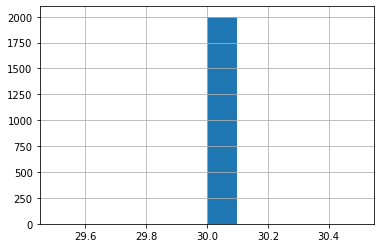

In [45]:
first_bin['SELFIES_length'].hist()

# Dataset to training

In [46]:
bins_SELFIES_length_to_be_used_half = bins_SELFIES_length_half.copy()
bins_SELFIES_length_to_be_used_half_2 = bins_SELFIES_length_half_2.copy()
#bins_SELFIES_length_to_be_used_half_2.reverse()
center_h = center

In [47]:
for i, element in enumerate(bins[1:11]):
    bins_SELFIES_length_to_be_used_half[i] = data[data['SELFIES_length'] == bins_SELFIES_length_half[i]][:int(one_size*element)]
    bins_SELFIES_length_to_be_used_half_2[i] = data[data['SELFIES_length'] == bins_SELFIES_length_half_2[i]][:int(one_size*element)]
    

In [48]:
bins_SELFIES_length_to_be_used_half[0].shape

(2000, 4)

In [49]:
bins_SELFIES_length_to_be_used_half[2].shape

(6000, 4)

In [50]:
bins_SELFIES_length_to_be_used_half_2[0].shape

(2000, 4)

In [51]:
center_h = data[data['SELFIES_length'] == 40][:int(one_size*center)]

In [52]:
center_h.shape

(21956, 4)

In [53]:
frames = (bins_SELFIES_length_to_be_used_half[0],
          bins_SELFIES_length_to_be_used_half[1],
          bins_SELFIES_length_to_be_used_half[2],
          bins_SELFIES_length_to_be_used_half[3],
          bins_SELFIES_length_to_be_used_half[4],
          bins_SELFIES_length_to_be_used_half[5],
          bins_SELFIES_length_to_be_used_half[6],
          bins_SELFIES_length_to_be_used_half[7],
          bins_SELFIES_length_to_be_used_half[8],
          bins_SELFIES_length_to_be_used_half[9],
          bins_SELFIES_length_to_be_used_half_2[0],
          bins_SELFIES_length_to_be_used_half_2[1],
          bins_SELFIES_length_to_be_used_half_2[2],
          bins_SELFIES_length_to_be_used_half_2[3],
          bins_SELFIES_length_to_be_used_half_2[4],
          bins_SELFIES_length_to_be_used_half_2[5],
          bins_SELFIES_length_to_be_used_half_2[6],
          bins_SELFIES_length_to_be_used_half_2[7],
          bins_SELFIES_length_to_be_used_half_2[8],
          bins_SELFIES_length_to_be_used_half_2[9],
          center_h)

In [54]:
data_to_training_and_validation = pd.concat(frames)

In [55]:
data_to_training_and_validation.shape

(241956, 4)

In [56]:
#data = data_to_training_and_validation.sort_values(by=['SELFIES_length'], ascending=True)

In [57]:
data_to_training_and_validation = data_to_training_and_validation.reset_index()

In [58]:
del data_to_training_and_validation['level_0']

In [59]:
data_to_training_and_validation.shape

(241956, 4)

<AxesSubplot:>

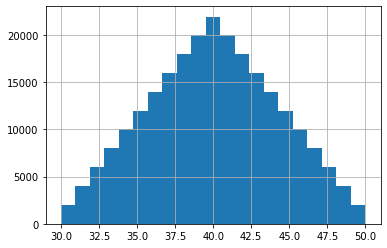

In [60]:
data_to_training_and_validation['SELFIES_length'].hist(bins=21)

## Make use of canonical form of SMILES

In [61]:
#Prepare molecule

In [62]:
mols = [Chem.MolFromSmiles(smi) for smi in data_to_training_and_validation['smiles']]

In [65]:
data_to_training_and_validation['SMILES_canonical'] = [Chem.MolToSmiles(mol, isomericSmiles=False) for mol in mols]

In [66]:
data_to_training_and_validation.head()

,index,smiles,SELFIES,SELFIES_length,SMILES_canonical
0,563932204,CNC(=O)CCCN1CCN(S(C)(=O)=O)[C@@H](C)C1,[C][N][C][=Branch1][C][=O][C][C][C][N][C][C][N...,30,CNC(=O)CCCN1CCN(S(C)(=O)=O)C(C)C1
1,1417550001,CCC[C@H](CNC(=O)CN1CCS(=O)(=O)CC1)OC,[C][C][C][C@H1][Branch2][Ring1][=Branch1][C][N...,30,CCCC(CNC(=O)CN1CCS(=O)(=O)CC1)OC
2,1388389819,CCOCC(=O)NC[C@@H](C)CNC(=O)c1ccn(C)n1,[C][C][O][C][C][=Branch1][C][=O][N][C][C@@H1][...,30,CCOCC(=O)NCC(C)CNC(=O)c1ccn(C)n1
3,1754026573,C[C@H](CCNCCO)NC(=O)c1ccc(C(N)=O)nc1,[C][C@H1][Branch1][#Branch1][C][C][N][C][C][O]...,30,CC(CCNCCO)NC(=O)c1ccc(C(N)=O)nc1
4,282862635,CC(C)(C)[C@H](NS(C)(=O)=O)C(=O)NCC#CCO,[C][C][Branch1][C][C][Branch1][C][C][C@H1][Bra...,30,CC(C)(C)C(NS(C)(=O)=O)C(=O)NCC#CCO


In [67]:
data_to_training_and_validation['SELFIES_canonical'] = [sf.encoder(smiles) for smiles in data_to_training_and_validation['SMILES_canonical']]

In [68]:
data_to_training_and_validation['SELFIES_length_canonical'] = [SELFIES_length(SELFIES) for SELFIES in data_to_training_and_validation['SELFIES_canonical']]

<AxesSubplot:>

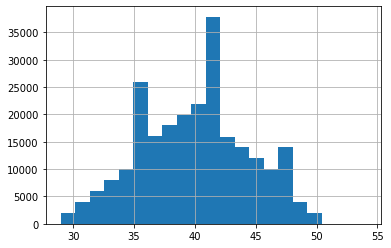

In [69]:
data_to_training_and_validation['SELFIES_length_canonical'].hist(bins=21)

In [70]:
data_to_training_and_validation.head()

,index,smiles,SELFIES,SELFIES_length,SMILES_canonical,SELFIES_canonical,SELFIES_length_canonical
0,563932204,CNC(=O)CCCN1CCN(S(C)(=O)=O)[C@@H](C)C1,[C][N][C][=Branch1][C][=O][C][C][C][N][C][C][N...,30,CNC(=O)CCCN1CCN(S(C)(=O)=O)C(C)C1,[C][N][C][=Branch1][C][=O][C][C][C][N][C][C][N...,30
1,1417550001,CCC[C@H](CNC(=O)CN1CCS(=O)(=O)CC1)OC,[C][C][C][C@H1][Branch2][Ring1][=Branch1][C][N...,30,CCCC(CNC(=O)CN1CCS(=O)(=O)CC1)OC,[C][C][C][C][Branch2][Ring1][=Branch1][C][N][C...,30
2,1388389819,CCOCC(=O)NC[C@@H](C)CNC(=O)c1ccn(C)n1,[C][C][O][C][C][=Branch1][C][=O][N][C][C@@H1][...,30,CCOCC(=O)NCC(C)CNC(=O)c1ccn(C)n1,[C][C][O][C][C][=Branch1][C][=O][N][C][C][Bran...,30
3,1754026573,C[C@H](CCNCCO)NC(=O)c1ccc(C(N)=O)nc1,[C][C@H1][Branch1][#Branch1][C][C][N][C][C][O]...,30,CC(CCNCCO)NC(=O)c1ccc(C(N)=O)nc1,[C][C][Branch1][#Branch1][C][C][N][C][C][O][N]...,30
4,282862635,CC(C)(C)[C@H](NS(C)(=O)=O)C(=O)NCC#CCO,[C][C][Branch1][C][C][Branch1][C][C][C@H1][Bra...,30,CC(C)(C)C(NS(C)(=O)=O)C(=O)NCC#CCO,[C][C][Branch1][C][C][Branch1][C][C][C][Branch...,30


In [71]:
#drop duplicates
data_to_training_and_validation = data_to_training_and_validation.drop_duplicates(subset=['SMILES_canonical'])


In [72]:
data_to_training_and_validation = data_to_training_and_validation.reset_index()

In [73]:
del data_to_training_and_validation['level_0']

### to be removed
-> Sn

-> Se

-> B

-> =P

-> P


In [74]:
data_to_training_and_validation = data_to_training_and_validation.reset_index()

In [75]:
del data_to_training_and_validation['level_0']

In [76]:
data_to_training_and_validation = data_to_training_and_validation[data_to_training_and_validation["SMILES_canonical"].str.contains("Sn") == False]
print(data_to_training_and_validation.shape)

data_to_training_and_validation = data_to_training_and_validation[data_to_training_and_validation["SMILES_canonical"].str.contains("Si") == False]
print(data_to_training_and_validation.shape)

data_to_training_and_validation = data_to_training_and_validation[data_to_training_and_validation["SELFIES_canonical"].str.contains("P") == False]
print(data_to_training_and_validation.shape)

data_to_training_and_validation = data_to_training_and_validation[data_to_training_and_validation["SELFIES_canonical"].str.contains("=P") == False]
print(data_to_training_and_validation.shape)

data_to_training_and_validation_bromium = data_to_training_and_validation[data_to_training_and_validation["SMILES_canonical"].str.contains("Br") == True]
print(data_to_training_and_validation_bromium.shape)

data_to_training_and_validation = data_to_training_and_validation[data_to_training_and_validation["SMILES_canonical"].str.contains("B") == False]
print(data_to_training_and_validation.shape)

frames = (data_to_training_and_validation, data_to_training_and_validation_bromium)
data_to_training_and_validation_to_be_used = pd.concat(frames)
print(data_to_training_and_validation_to_be_used.shape)



data_to_training_and_validation_to_be_used = data_to_training_and_validation_to_be_used.reset_index()
del data_to_training_and_validation_to_be_used['level_0']
print(data_to_training_and_validation_to_be_used.shape)

data_to_training_and_validation_to_be_used = data_to_training_and_validation_to_be_used.sort_values(by=['SELFIES_length'], ascending=True)

(233694, 7)
(233688, 7)
(208691, 7)
(208691, 7)
(15513, 7)
(193163, 7)
(208676, 7)
(208676, 7)


In [77]:
one_size = 121000/sum(one_part_size)
one_size

1000.0

In [78]:
bins_SELFIES_length_to_be_used_half = bins_SELFIES_length_half.copy()
bins_SELFIES_length_to_be_used_half_2 = bins_SELFIES_length_half_2.copy()
#bins_SELFIES_length_to_be_used_half_2.reverse()
center_h = center

In [79]:
for i, element in enumerate(bins[1:11]):
    bins_SELFIES_length_to_be_used_half[i] = data_to_training_and_validation_to_be_used[data_to_training_and_validation_to_be_used['SELFIES_length_canonical'] == bins_SELFIES_length_half[i]][:int(one_size*element)]
    bins_SELFIES_length_to_be_used_half_2[i] = data_to_training_and_validation_to_be_used[data_to_training_and_validation_to_be_used['SELFIES_length_canonical'] == bins_SELFIES_length_half_2[i]][:int(one_size*element)]
    

In [80]:
center_h = data_to_training_and_validation_to_be_used[data_to_training_and_validation_to_be_used['SELFIES_length_canonical'] == 40][:int(one_size*center)]

In [81]:
frames = (bins_SELFIES_length_to_be_used_half[0],
          bins_SELFIES_length_to_be_used_half[1],
          bins_SELFIES_length_to_be_used_half[2],
          bins_SELFIES_length_to_be_used_half[3],
          bins_SELFIES_length_to_be_used_half[4],
          bins_SELFIES_length_to_be_used_half[5],
          bins_SELFIES_length_to_be_used_half[6],
          bins_SELFIES_length_to_be_used_half[7],
          bins_SELFIES_length_to_be_used_half[8],
          bins_SELFIES_length_to_be_used_half[9],
          bins_SELFIES_length_to_be_used_half_2[0],
          bins_SELFIES_length_to_be_used_half_2[1],
          bins_SELFIES_length_to_be_used_half_2[2],
          bins_SELFIES_length_to_be_used_half_2[3],
          bins_SELFIES_length_to_be_used_half_2[4],
          bins_SELFIES_length_to_be_used_half_2[5],
          bins_SELFIES_length_to_be_used_half_2[6],
          bins_SELFIES_length_to_be_used_half_2[7],
          bins_SELFIES_length_to_be_used_half_2[8],
          bins_SELFIES_length_to_be_used_half_2[9],
          center_h)

In [82]:
data_to_training_and_validation = pd.concat(frames)

In [83]:
data_to_training_and_validation.head()

,index,smiles,SELFIES,SELFIES_length,SMILES_canonical,SELFIES_canonical,SELFIES_length_canonical
0,563932204,CNC(=O)CCCN1CCN(S(C)(=O)=O)[C@@H](C)C1,[C][N][C][=Branch1][C][=O][C][C][C][N][C][C][N...,30,CNC(=O)CCCN1CCN(S(C)(=O)=O)C(C)C1,[C][N][C][=Branch1][C][=O][C][C][C][N][C][C][N...,30
1161,51885268,O=C(Cn1cc([N+](=O)[O-])cn1)N1CC[C@@H](CO)C1,[O][=C][Branch1][S][C][N][C][=C][Branch1][=Bra...,30,O=C(Cn1cc([N+](=O)[O-])cn1)N1CCC(CO)C1,[O][=C][Branch1][S][C][N][C][=C][Branch1][=Bra...,30
1160,1099938503,COCCCN1CC[C@@H](NC(=O)c2cnco2)[C@H](O)C1,[C][O][C][C][C][N][C][C][C@@H1][Branch1][=N][N...,30,COCCCN1CCC(NC(=O)c2cnco2)C(O)C1,[C][O][C][C][C][N][C][C][C][Branch1][=N][N][C]...,30
1159,1368537405,C[C@@H](O)CNC[C@H]1CN(C(=O)Cc2cnc[nH]2)CCO1,[C][C@@H1][Branch1][C][O][C][N][C][C@H1][C][N]...,30,CC(O)CNCC1CN(C(=O)Cc2cnc[nH]2)CCO1,[C][C][Branch1][C][O][C][N][C][C][C][N][Branch...,30
1158,1379339000,C[C@H](CNCc1cn(C)nn1)NC(=O)COCC1CC1,[C][C@H1][Branch1][=C][C][N][C][C][=C][N][Bran...,30,CC(CNCc1cn(C)nn1)NC(=O)COCC1CC1,[C][C][Branch1][=C][C][N][C][C][=C][N][Branch1...,30


<AxesSubplot:>

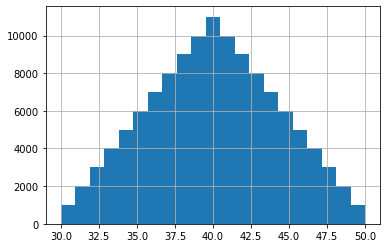

In [84]:
data_to_training_and_validation['SELFIES_length_canonical'].hist(bins=21)

In [85]:
data_to_training_and_validation = data_to_training_and_validation.reset_index()
del data_to_training_and_validation['level_0']

In [86]:
resulting_file_name = "zinc20_"+'selected_to_create_model'+"_processed.parquet"
resulting_df_path = Path("../data")/resulting_file_name ##Important bug
data_to_training_and_validation.to_parquet(resulting_df_path.absolute().as_posix())

### RORgamma active compounds : doi: 10.1038/aps.2014.120

In [87]:
list_of_compounds_names = ['20-Hydroxycholesterol', '22(R)-Hydroxy cholesterol', '25-Hydroxycholesterol','Ursolic acid','Digoxin','T0901317', 
                           'SR1001', 'SR1078', 'SR-1555', 'SR2211', 'ML209', 'N-(1-(4-(1,1,1,3,3,3-hexafluoro-2-hydroxypropan-2-yl)benzyl)-1,2,3,4-tetrahydroquinolin-6-yl)acetamide', '2,4-difluoro-N-(1-((4-fluorophenyl)sulfonyl)-1,2,3,4-tetrahydroquinolin-7-yl)benzenesulfonamide', 
                          '2-Chloro-6-fluoro-N-(1-((4-fluorophenyl)sulfonyl)-1,2,3,4-tetrahydroquinolin-7-yl)benzamide', '(S)-2-fluoro-N-(3-methyl-1-(m-tolylsulfonyl)-2,3-dihydro-1H-pyrido[2,3-b][1,4]oxazin-7-yl)-6-(trifluoromethyl)benzamide', 
                           '(S)-2-fluoro-N-(3-methyl-1-(m-tolylsulfonyl)-2,3-dihydro-1H-pyrido[2,3-b][1,4]oxazin-7-yl)-6-(trifluoromethyl)benzamide',
                          '4-(1-(2-Chloro-6-cyclopropylbenzoyl)-7-fluoro-1H-indazol-3-yl)-3-fluorobenzoicacid', '4-(1-(2-Chloro-6-(trifluoromethyl)benzoyl)-7-fluoro-1H-indazol-3-yl)-2-hydroxycyclohex-3-enecarboxylic acid', 'GSK-1a', 'GSK-1b', 'GSK-1c', 'GSK-6a', 'GSK-8h', 'GSK-9g',
                          'GSK-2', 'GSK-13', 'GSK-21', '2-(4-(Ethylsulfonyl)phenyl)-N-(6-(3-fluorophenoxy)-[1,1′-biphenyl]-3-yl)acetamide', 'N-(6-(3,5-difluorophenoxy)-3′-fluoro-[1,1′-biphenyl]-3-yl)-2-(4-(N-methylsulfamoyl)phenyl)acetamide',
                          'N-(4-Ethylphenyl)-3-(hydroxymethyl)-Nisobutyl-4-((tetrahydro-2H-pyran-4-yl)methoxy)benzenesulfonamide', 'N-(4-chlorophenyl)-4-((3,5-dimethylisoxazol-4-yl)methoxy)-N-isobutylbenzenesulfonamide',
                          'N-(2,4-dimethylphenyl)-4-(2-hydroxy2-(pyridin-4-yl)ethoxy)-N-isobutylbenzenesulfonamide', 'N-isobutyl-N-((5-(4-(methylsulfonyl)phenyl)thiophen-2-yl)methyl)-1-phenylmethanesulfonamide',
                          'N-(4-(4-acetylpiperazin-1-yl)benzyl)-Nisobutyl-1-phenylmethanesulfonamide', 'N-(3,4-dimethoxyphenyl)-1-ethyl-2-oxo-1,2-dihydrobenzo[cd]indole-6-sulfonamide', 'JTE-151']

In [88]:
list_of_compounds_smiles = ['CC(C)CCC[C@@](C)([C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C)O',
                           'C[C@@H]([C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C)[C@@H](CCC(C)C)O',
                           'C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C',
                           'C[C@@H]1CC[C@@]2(CC[C@@]3(C(=CC[C@H]4[C@]3(CC[C@@H]5[C@@]4(CC[C@@H](C5(C)C)O)C)C)[C@@H]2[C@H]1C)C)C(=O)O',
                           'C[C@@H]1[C@H]([C@H](C[C@@H](O1)O[C@@H]2[C@H](O[C@H](C[C@@H]2O)O[C@@H]3[C@H](O[C@H](C[C@@H]3O)O[C@H]4CC[C@]5([C@@H](C4)CC[C@@H]6[C@@H]5C[C@H]([C@]7([C@@]6(CC[C@@H]7C8=CC(=O)OC8)O)C)O)C)C)C)O)O',
                           'C1=CC=C(C=C1)S(=O)(=O)N(CC(F)(F)F)C2=CC=C(C=C2)C(C(F)(F)F)(C(F)(F)F)O',
                           'CC1=C(SC(=N1)NC(=O)C)S(=O)(=O)NC2=CC=C(C=C2)C(C(F)(F)F)(C(F)(F)F)O',
                           'C1=CC(=CC=C1C(=O)NC2=CC=C(C=C2)C(C(F)(F)F)(C(F)(F)F)O)C(F)(F)F',
                           'CC(=O)N1CCN(CC1)CC2=CC=C(C=C2)C3=CC=C(C=C3)C(C(F)(F)F)(C(F)(F)F)O',
                           'C1CN(CCN1CC2=CC=C(C=C2)C3=C(C=C(C=C3)C(C(F)(F)F)(C(F)(F)F)O)F)CC4=CC=NC=C4',
                           'C[C@@H]1C[C@@H](CN(C1)C(=O)CC(C2=CC3=C(C=C2)OCO3)C4=C(C=C(C=C4OC)OC)O)C',
                           'CC(=O)NC1=CC2=C(C=C1)N(CC1=CC=C(C=C1)C(O)(C(F)(F)F)C(F)(F)F)CCC2',
                           'C1CC2=C(C=C(C=C2)NS(=O)(=O)C3=C(C=C(C=C3)F)F)N(C1)S(=O)(=O)C4=CC=C(C=C4)F',
                           'C1CC2=C(C=C(C=C2)NC(=O)C3=C(C=CC=C3Cl)F)N(C1)S(=O)(=O)C4=CC=C(C=C4)F',
                           'CC1CN(C2=C(O1)N=CC(NC(=O)C1=C(F)C=CC=C1C(F)(F)F)=C2)S(=O)(=O)C1=CC=CC(C)=C1',
                           'OC(=O)C1=CC(F)=C(C=C1)C1=NN(C(=O)C2=C(C=CC=C2Cl)C2CC2)C2=C1C=CC=C2F',
                           'OC1C=C(CCC1C(O)=O)C1=NN(C(=O)C2=C(Cl)C=CC=C2C(F)(F)F)C2=C1C=CC=C2F',
                           'OC1C=C(CCC1C(O)=O)C1=NN(C(=O)C2=C(Cl)C=CC=C2C(F)(F)F)C2=C(F)C=CC=C12',
                           'CC1=CC=CC(=C1)C(=O)NC1=CC(=NO1)C1=CC=CC=C1',
                           'CC1=C(NC(=O)C2=NC3=C(C)C=C(C)C=C3S2)SC=C1',
                           'CCC(=O)NC1=CC2=NN(N=C2C=C1)C1=CC=C(CC)C=C1',
                           'CCS(=O)(=O)C1=CC=C(CC(=O)NC2=NC(=CS2)C2=CC(Cl)=CC=C2Cl)C=C1',
                           'CCS(=O)(=O)C1=CC=C(CC(=O)NC2=NC(=C(S2)C(=O)C2=C(Cl)C=CC=C2)C2=CC=CC(Cl)=C2)C=C1',
                           'CCS(=O)(=O)C1=CC=C(CC(=O)NC2=CC(=C(S2)C(=O)C2=CC(F)=CC=C2)C2=CC(Cl)=CC=C2)C=C1',
                           'CCCN(CC1=CC=CC=C1)C1=CC=C(NC(=O)CC2=CC=C(C=C2)S(=O)(=O)CC)C=C1',
                           'CCS(=O)(=O)C1=CC=C(CC(=O)NC2=CC=C3N(CCC4=CC=C(C=C4)C(F)(F)F)C=CC3=C2)C=C1',
                           'CCS(=O)(=O)C1=CC=C(CC(=O)NC2=CC=C3N(CCC4=C(Cl)C=C(Cl)C=C4)C=CC3=C2)C=C1',
                           'CCS(=O)(=O)C1=CC=C(CC(=O)NC2=CC(=C(OC3=CC=CC(F)=C3)C=C2)C2=CC=CC=C2)C=C1',
                           'CNS(=O)(=O)C1=CC=C(CC(=O)NC2=CC(=C(OC3=CC(F)=CC(F)=C3)C=C2)C2=CC=CC(F)=C2)C=C1',
                           'CCC1=CC=C(C=C1)N(CC(C)C)S(=O)(=O)C2=CC(=C(C=C2)OCC3CCOCC3)CO',
                           'CC(C)CN(C1=CC=C(Cl)C=C1)S(=O)(=O)C1=CC=C(OCC2=C(C)ON=C2C)C=C1',
                           'CC(C)CN(C1=CC=C(C)C=C1C)S(=O)(=O)C1=CC=C(OCC(O)C2=CC=NC=C2)C=C1',
                           'CC(C)CN(CC1=CC=C(S1)C1=CC=C(C=C1)S(C)(=O)=O)S(=O)(=O)CC1=CC=CC=C1',
                           'CC(C)CN(CC1=CC=C(C=C1)N1CCN(CC1)C(C)=O)S(=O)(=O)CC1=CC=CC=C1',
                           'CCN1C(=O)C2=CC=CC3=C(C=CC1=C23)S(=O)(=O)NC1=CC(OC)=C(OC)C=C1',
                           'CC(C)CC1=CC(=NO1)C1=C(C2CC2)C(=NO1)C(CCC(O)=O)CC(=O)NC1=CC=C(C)C=C1Cl']

In [89]:
len(list_of_compounds_names)

36

In [90]:
len(list_of_compounds_smiles)

36

In [91]:
list_of_compounds_names

['20-Hydroxycholesterol',
 '22(R)-Hydroxy cholesterol',
 '25-Hydroxycholesterol',
 'Ursolic acid',
 'Digoxin',
 'T0901317',
 'SR1001',
 'SR1078',
 'SR-1555',
 'SR2211',
 'ML209',
 'N-(1-(4-(1,1,1,3,3,3-hexafluoro-2-hydroxypropan-2-yl)benzyl)-1,2,3,4-tetrahydroquinolin-6-yl)acetamide',
 '2,4-difluoro-N-(1-((4-fluorophenyl)sulfonyl)-1,2,3,4-tetrahydroquinolin-7-yl)benzenesulfonamide',
 '2-Chloro-6-fluoro-N-(1-((4-fluorophenyl)sulfonyl)-1,2,3,4-tetrahydroquinolin-7-yl)benzamide',
 '(S)-2-fluoro-N-(3-methyl-1-(m-tolylsulfonyl)-2,3-dihydro-1H-pyrido[2,3-b][1,4]oxazin-7-yl)-6-(trifluoromethyl)benzamide',
 '(S)-2-fluoro-N-(3-methyl-1-(m-tolylsulfonyl)-2,3-dihydro-1H-pyrido[2,3-b][1,4]oxazin-7-yl)-6-(trifluoromethyl)benzamide',
 '4-(1-(2-Chloro-6-cyclopropylbenzoyl)-7-fluoro-1H-indazol-3-yl)-3-fluorobenzoicacid',
 '4-(1-(2-Chloro-6-(trifluoromethyl)benzoyl)-7-fluoro-1H-indazol-3-yl)-2-hydroxycyclohex-3-enecarboxylic acid',
 'GSK-1a',
 'GSK-1b',
 'GSK-1c',
 'GSK-6a',
 'GSK-8h',
 'GSK-9g',
 'GSK

In [92]:
list_of_compounds_smiles

['CC(C)CCC[C@@](C)([C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C)O',
 'C[C@@H]([C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C)[C@@H](CCC(C)C)O',
 'C[C@H](CCCC(C)(C)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C',
 'C[C@@H]1CC[C@@]2(CC[C@@]3(C(=CC[C@H]4[C@]3(CC[C@@H]5[C@@]4(CC[C@@H](C5(C)C)O)C)C)[C@@H]2[C@H]1C)C)C(=O)O',
 'C[C@@H]1[C@H]([C@H](C[C@@H](O1)O[C@@H]2[C@H](O[C@H](C[C@@H]2O)O[C@@H]3[C@H](O[C@H](C[C@@H]3O)O[C@H]4CC[C@]5([C@@H](C4)CC[C@@H]6[C@@H]5C[C@H]([C@]7([C@@]6(CC[C@@H]7C8=CC(=O)OC8)O)C)O)C)C)C)O)O',
 'C1=CC=C(C=C1)S(=O)(=O)N(CC(F)(F)F)C2=CC=C(C=C2)C(C(F)(F)F)(C(F)(F)F)O',
 'CC1=C(SC(=N1)NC(=O)C)S(=O)(=O)NC2=CC=C(C=C2)C(C(F)(F)F)(C(F)(F)F)O',
 'C1=CC(=CC=C1C(=O)NC2=CC=C(C=C2)C(C(F)(F)F)(C(F)(F)F)O)C(F)(F)F',
 'CC(=O)N1CCN(CC1)CC2=CC=C(C=C2)C3=CC=C(C=C3)C(C(F)(F)F)(C(F)(F)F)O',
 'C1CN(CCN1CC2=CC=C(C=C2)C3=C(C=C(C=C3)C(C(F)(F)F)(C(F)(F)F)O)F)CC4=CC=NC=C4',
 'C[C@@H]1C[C@@H](CN(C1)C(=O)CC(C2=CC3=C(C=C2)OCO3)C4=C(C=C(C

In [93]:
def print_name_and_structure(name, structure):
    print(list_of_compounds_names[name])
    mol = Chem.MolFromSmiles(list_of_compounds_smiles[structure])
    return mol

Number of name12
Number of structure12
2,4-difluoro-N-(1-((4-fluorophenyl)sulfonyl)-1,2,3,4-tetrahydroquinolin-7-yl)benzenesulfonamide


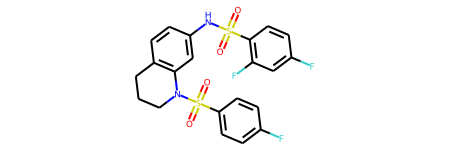

In [94]:
print_name_and_structure(int(input("Number of name")), int(input("Number of structure")))

## Create dataframe from RORgamma drugs

In [95]:
dataframe = pd.DataFrame(data=list_of_compounds_names, columns=['Compound name'])

In [96]:
mols = [Chem.MolFromSmiles(smi) for smi in list_of_compounds_smiles]

In [97]:
dataframe['SMILES_canonical']  = [Chem.MolToSmiles(mol, isomericSmiles=False) for mol in mols]

In [98]:
dataframe['SELFIES'] = [sf.encoder(smiles) for smiles in dataframe['SMILES_canonical']]

In [99]:
dataframe['SELFIES_length'] = [SELFIES_length(SELFIES) for SELFIES in dataframe['SELFIES']]

In [100]:
dataframe['SELFIES_length']

0      48
1      48
2      48
3      63
4     103
5      60
6      61
7      57
8      63
9      70
10     59
11     56
12     58
13     55
14     66
15     60
16     61
17     61
18     35
19     33
20     34
21     48
22     63
23     65
24     52
25     64
26     58
27     60
28     66
29     54
30     52
31     56
32     55
33     55
34     53
35     61
Name: SELFIES_length, dtype: int64

In [101]:
dataframe.to_excel('RORgamma_active_compounds.xlsx')